In [2]:
from __future__ import division
import time
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import cv2 
from util import *
from darknet import Darknet
from preprocess import prep_image, inp_to_image, letterbox_image
import pandas as pd
import random 
import pickle as pkl
import argparse


def get_test_input(input_dim, CUDA):
    img = cv2.imread("dog-cycle-car.png")
    img = cv2.resize(img, (input_dim, input_dim)) 
    img_ =  img[:,:,::-1].transpose((2,0,1))
    img_ = img_[np.newaxis,:,:,:]/255.0
    img_ = torch.from_numpy(img_).float()
    img_ = Variable(img_)
    
    if CUDA:
        img_ = img_.cuda()
    
    return img_

def prep_image(img, inp_dim):
    """
    Prepare image for inputting to the neural network. 
    
    Returns a Variable 
    """

    orig_im = img
    dim = orig_im.shape[1], orig_im.shape[0]
    img = (letterbox_image(orig_im, (inp_dim, inp_dim)))
    img_ = img[:,:,::-1].transpose((2,0,1)).copy()
    img_ = torch.from_numpy(img_).float().div(255.0).unsqueeze(0)
    return img_, orig_im, dim

def write(x, img):
    c1 = tuple(x[1:3].int())
    c2 = tuple(x[3:5].int())
    cls = int(x[-1])
    label = "{0}".format(classes[cls])
    color = random.choice(colors)
    cv2.rectangle(img, c1, c2,color, 1)
    t_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_PLAIN, 1 , 1)[0]
    c2 = c1[0] + t_size[0] + 3, c1[1] + t_size[1] + 4
    cv2.rectangle(img, c1, c2,color, -1)
    cv2.putText(img, label, (c1[0], c1[1] + t_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1, [225,255,255], 1);
    return img

def arg_parse():
    """
    Parse arguements to the detect module
    
    """
    
    
    parser = argparse.ArgumentParser(description='YOLO v3 Video Detection Module')
   
    parser.add_argument("--video", dest = 'video', help = 
                        "Video to run detection upon",
                        default = "video.avi", type = str)
    parser.add_argument("--dataset", dest = "dataset", help = "Dataset on which the network has been trained", default = "pascal")
    parser.add_argument("--confidence", dest = "confidence", help = "Object Confidence to filter predictions", default = 0.5)
    parser.add_argument("--nms_thresh", dest = "nms_thresh", help = "NMS Threshhold", default = 0.4)
    parser.add_argument("--cfg", dest = 'cfgfile', help = 
                        "Config file",
                        default = "cfg/yolov3.cfg", type = str)
    parser.add_argument("--weights", dest = 'weightsfile', help = 
                        "weightsfile",
                        default = "yolov3.weights", type = str)
    parser.add_argument("--reso", dest = 'reso', help = 
                        "Input resolution of the network. Increase to increase accuracy. Decrease to increase speed",
                        default = "416", type = str)
    return parser.parse_args()




ModuleNotFoundError: No module named 'util'

In [6]:


confidence = float(0.7)
nms_thesh = float(0.4)
start = 0

CUDA = torch.cuda.is_available()

num_classes = 80

CUDA = torch.cuda.is_available()

bbox_attrs = 5 + num_classes

print("Loading network.....")
model = Darknet(args.cfgfile)
model.load_weights(args.weightsfile)
print("Network successfully loaded")

model.net_info["height"] = args.reso
inp_dim = int(model.net_info["height"])
assert inp_dim % 32 == 0 
assert inp_dim > 32

if CUDA:
    model.cuda()

model(get_test_input(inp_dim, CUDA), CUDA)

model.eval()

videofile = args.video

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frames = 0
start = time.time()    
while cap.isOpened():

    ret, frame = cap.read()
    if ret:


        img, orig_im, dim = prep_image(frame, inp_dim)

        im_dim = torch.FloatTensor(dim).repeat(1,2)                        


        if CUDA:
            im_dim = im_dim.cuda()
            img = img.cuda()

        with torch.no_grad():   
            output = model(Variable(img), CUDA)
        output = write_results(output, confidence, num_classes, nms = True, nms_conf = nms_thesh)

        if type(output) == int:
            frames += 1
            print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))
            cv2.imshow("frame", orig_im)
            key = cv2.waitKey(1)
            if key & 0xFF == ord('q'):
                break
            continue




        im_dim = im_dim.repeat(output.size(0), 1)
        scaling_factor = torch.min(inp_dim/im_dim,1)[0].view(-1,1)

        output[:,[1,3]] -= (inp_dim - scaling_factor*im_dim[:,0].view(-1,1))/2
        output[:,[2,4]] -= (inp_dim - scaling_factor*im_dim[:,1].view(-1,1))/2

        output[:,1:5] /= scaling_factor

        for i in range(output.shape[0]):
            output[i, [1,3]] = torch.clamp(output[i, [1,3]], 0.0, im_dim[i,0])
            output[i, [2,4]] = torch.clamp(output[i, [2,4]], 0.0, im_dim[i,1])

        classes = load_classes('data/coco.names')
        colors = pkl.load(open("pallete", "rb"))

        list(map(lambda x: write(x, orig_im), output))


        cv2.imshow("frame", orig_im)
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        frames += 1
        print("FPS of the video is {:5.2f}".format( frames / (time.time() - start)))


    else:
        break








usage: ipykernel_launcher.py [-h] [--video VIDEO] [--dataset DATASET]
                             [--confidence CONFIDENCE]
                             [--nms_thresh NMS_THRESH] [--cfg CFGFILE]
                             [--weights WEIGHTSFILE] [--reso RESO]
ipykernel_launcher.py: error: unrecognized arguments: -f /Users/Eren/Library/Jupyter/runtime/kernel-16db8a81-c358-43b1-a8db-14ac9259388c.json


SystemExit: 2

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Load Dependencies

In [1]:

# Some code sourced from:

#############################################
# Object detection - YOLO - OpenCV
# Author : Arun Ponnusamy   (July 16, 2018)
# Website : http://www.arunponnusamy.com
############################################


import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd


from scipy.spatial import distance
import tensorflow as tf
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras import backend as K


%matplotlib inline





Using TensorFlow backend.


# Functions

In [2]:




def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h):

    label = str(classes[class_id])

    color = COLORS[class_id]

    cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)

    cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


def get_yolo_output(image):

    Width = image.shape[1]
    Height = image.shape[0]
    scale = 0.00392

    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))


    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
    
    boxes_nms = []
    class_ids_nms = []
    confidences_nms = []
    
    
    for i in indices:
        i = i[0]
        boxes_nms.append(boxes[i])
        class_ids_nms.append(class_ids[i])
        confidences_nms.append(confidences[i])
    
    return boxes_nms, class_ids_nms, confidences_nms


def print_on_image(image, boxes_nms, class_ids_nms, confidences_nms):

    #cv2.polylines(image,swalk_pts,True,(0,255,255),thickness=3)
    #cv2.polylines(image,lane_pts,True,(255,0,255),thickness=3)
    
    
    for i, box in enumerate(boxes_nms):
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]
        draw_prediction(image, class_ids_nms[i], confidences_nms[i], round(x), round(y), round(x+w), round(y+h))
        

        
def create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background):
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            cv2.rectangle(grid_vehicles, (x,y), (x_plus_w,y_plus_h), vehicle_w, -1)


        elif class_ids_nms[i]==0:  # Person
            
            cv2.rectangle(grid_person, (x,y), (x_plus_w,y_plus_h), person_w, -1) 
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            cv2.rectangle(grid_bicycle, (x,y), (x_plus_w,y_plus_h), bicycle_w, -1)
            
        else:
            continue
    
    grid_overflow = np.zeros((grid_y_size,grid_x_size), dtype = np.int16)    
    #grid_overflow = np.array([grid_background,grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = np.array([grid_vehicles,grid_person,grid_bicycle])
    grid_overflow = grid_overflow.sum(axis=0)
    grid_overflow[grid_overflow>127] = 127
    grid_overflow[grid_overflow<-128] = -128
    grid = np.array(grid_overflow,dtype=np.int8)

    return grid
       

    
def create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor, grid_background,
               vehicles=False,
               persons=False,
               bicycles=False):
    
    options = [vehicles, persons, bicycles]
    num_channels = options.count(True)
    
    grid = np.zeros((num_channels,grid_y_size,grid_x_size), dtype = bool)
    
    
    grid_vehicles   = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_person     = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    grid_bicycle    = np.zeros((grid_y_size,grid_x_size), dtype = bool)
    
    present_val = 1
    
    for i, box in enumerate(boxes_nms):

        x = round(box[0])
        y = round(box[1])
        w = box[2]
        h = box[3]

        x_plus_w = round(x+w)
        y_plus_h = round(y+h)


        x = round(x/grid_scaling_factor)
        y = round(y/grid_scaling_factor)
        x_plus_w = round(x_plus_w/grid_scaling_factor)
        y_plus_h = round(y_plus_h/grid_scaling_factor)
        
        
        if class_ids_nms[i] in [2, 3, 5, 6, 7]:  # Motorized vehicles [car, motorcycle, bus, train, truck]
            
            grid_vehicles[y:y_plus_h+1,x:x_plus_w+1] = present_val

        elif class_ids_nms[i]==0:  # Person
            
            grid_person[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        elif class_ids_nms[i]==1:  # Bicycle
            
            grid_bicycle[y:y_plus_h+1,x:x_plus_w+1] = present_val
            
        else:
            continue


    j = 0
    if vehicles:
        grid[j] = grid_vehicles
        j = j+1
    if persons:
        grid[j] = grid_person
        j = j+1
    if bicycles:
        grid[j] = grid_bicycle
        j = j+1
    
    return grid
       



# Spatial and Time Scaling Coefficients
* "seconds" represents the time intervals in seconds at which samples will be taken from the video.    
* "grid_scaling_factor" represents the factor by which the grid will be shrunk.

In [3]:
seconds = 0.25
grid_scaling_factor = 32

# Background Areas

In [4]:

########### Background Areas #############

#lanes

lane_pts = []
lane_pts_1 = np.array([[540,0],[483,303],[314,555],[0,915],[0,1080],[625,1080],[708,719],[745,544],[763,362],[687,154],[791,310],[822,396],[835,582],[806,861],[779,1080],[1114,1080],[1060,664],[988,418],[924,317],[662,0]], np.int32)
lane_pts_1 = lane_pts_1.reshape((-1,1,2))

lane_pts_2 = np.array([[1920,600],[1832,660],[1760,773],[1692,907],[1660,1080],[1140,1080],[1245,893],[1418,691],[1590,569],[1782,480],[1920,421]], np.int32)
lane_pts_2 = lane_pts_2.reshape((-1,1,2))

lane_pts.append(lane_pts_1)
lane_pts.append(lane_pts_2)


lane_pts_grid = []

for pts in lane_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    lane_pts_grid.append(grid_pts)



#sidewalks

swalk_pts = []
swalk_pts_1 = np.array([[454,0],[540,0],[514,143],[448,149],[383,306],[483,303],[314,555],[0,915],[0,425],[179,356]], np.int32)
swalk_pts_1 = swalk_pts_1.reshape((-1,1,2))

swalk_pts_2 = np.array([[986,265],[1173,264],[1268,319],[1484,291],[1600,296],[1920,224],[1920,281],[1280,529],[1151,500]], np.int32)
swalk_pts_2 = swalk_pts_2.reshape((-1,1,2))

swalk_pts_3 = np.array([[1920,600],[1920,1080],[1660,1080],[1692,907],[1760,773],[1832,660]], np.int32)
swalk_pts_3 = swalk_pts_3.reshape((-1,1,2))


swalk_pts.append(swalk_pts_1)
swalk_pts.append(swalk_pts_2)
swalk_pts.append(swalk_pts_3)


swalk_pts_grid = []

for pts in swalk_pts:
    grid_pts = np.divide(pts,grid_scaling_factor)
    np.round_(grid_pts)
    grid_pts = np.array(grid_pts,dtype=np.int32)
    swalk_pts_grid.append(grid_pts)
    


#out of bounds (oob) areas


#median spaces



## Grid Weights

In [5]:

########### Grid Weights #############


lane_w = 32
swalk_w = -32
oob_w = -127
med_sp_w = 0


vehicle_w = 64
person_w = -64
bicycle_w = 32

# obj_w = 




## Load Model

In [6]:

##################################################################### 

classes = None

with open('yolov3.txt', 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

GREYSCALE = np.random.uniform(0, 255, size=(len(classes)))

net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')


#image = cv2.imread('dog.jpg')

#####################################################################




## Load Video

In [216]:





videofile = 'videos/FYP_Traffic_Footage_Embankment.mp4'

cap = cv2.VideoCapture(videofile)

assert cap.isOpened(), 'Cannot capture source'

frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
success,image = cap.read()



fps = cap.get(cv2.CAP_PROP_FPS) # Gets the frames per second
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT) # Gets the total number of frames




frame_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # Gets the frame width
frame_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # Gets the frame width

grid_x_size = int(round(frame_width/grid_scaling_factor))
grid_y_size = int(round(frame_height/grid_scaling_factor))


multiplier = int(round(fps * seconds))
num_scenes = int(round(num_frames/(fps * seconds))+1)


grids_v       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_p       = np.zeros((num_scenes,1,grid_y_size,grid_x_size), dtype = bool)
grids_vp      = np.zeros((num_scenes,2,grid_y_size,grid_x_size), dtype = bool)
grids_vpb     = np.zeros((num_scenes,3,grid_y_size,grid_x_size), dtype = bool)


frameIds    = np.zeros((num_scenes), dtype = np.int32)
time_sec_count = np.zeros((num_scenes), dtype = np.int32)


#################### Initiate Process ################

#################### Create Background Grid ################

grid_background = np.zeros((grid_y_size,grid_x_size), dtype = np.int8)

# Mark background
cv2.fillPoly(grid_background,lane_pts_grid,lane_w)
cv2.fillPoly(grid_background,swalk_pts_grid,swalk_w)

print('FPS: ', fps)



FPS:  23.976023976023978


## Process Video

In [8]:


############################################################

i = 0

while success:

    if frameId % multiplier == 0:
        

        
#############################################################

        
        boxes_nms, class_ids_nms, confidences_nms = get_yolo_output(image)
        
        second_count = round(frameId/fps)
        
        
        grid = create_grid(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background,
                           vehicles = True,
                           persons = True,
                           bicycles = True)
        
        
        
        grids_v[i] = grid[0]
        grids_p[i] = grid[1]
        grids_vp[i] = grid[:2]
        grids_vpb[i] = grid
        
        
        
        frameIds[i] = frameId
        time_sec_count[i] = second_count
        
        
        
        
        
        
        if frameId % (40*multiplier) == 0:
            
            print ('Time processed = ', int(second_count/60), ' mins ', second_count%60, ' seconds')
            
            
            grid_rep = np.array(grid[1],dtype=np.uint8)
            grid_rep = np.multiply(grid_rep,255)
            cv2.imwrite("output/representations/rep%d.jpg" % frameId, grid_rep)
        
            grid_image = create_grid_image(boxes_nms, class_ids_nms, confidences_nms, grid_scaling_factor,grid_background)
            grid_image_16_bit = np.array(grid_image,dtype=np.int16)
            grid_image_16_bit = np.add(grid_image_16_bit,128)
            grid_image_unsigned = np.array(grid_image_16_bit,dtype=np.uint8)
            cv2.imwrite("output/grids/grid%d.jpg" % frameId, grid_image_unsigned)

            print_on_image(image, boxes_nms, class_ids_nms, confidences_nms)

            cv2.imwrite("output/frames/frame%d.jpg" % frameId, image)
        
        
        i= i+1
        
        #print ('One image done')
        
        
    frameId = int(round(cap.get(1))) #current frame number, rounded b/c sometimes you get frame intervals which aren't integers...this adds a little imprecision but is likely good enough
    success, image = cap.read()


        #plt.figure(figsize = (15, 15))
        #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    
#cv2.imwrite("object-detection.jpg", image)
#cv2.destroyAllWindows()

print (i)

cap.release()



print ("Complete")





Time processed =  0  mins  0  seconds
Time processed =  0  mins  10  seconds
Time processed =  0  mins  20  seconds
Time processed =  0  mins  30  seconds
Time processed =  0  mins  40  seconds
Time processed =  0  mins  50  seconds
Time processed =  1  mins  0  seconds
Time processed =  1  mins  10  seconds
Time processed =  1  mins  20  seconds
Time processed =  1  mins  30  seconds
Time processed =  1  mins  40  seconds
Time processed =  1  mins  50  seconds
Time processed =  2  mins  0  seconds
Time processed =  2  mins  10  seconds
Time processed =  2  mins  20  seconds
Time processed =  2  mins  30  seconds
Time processed =  2  mins  40  seconds
Time processed =  2  mins  50  seconds
Time processed =  3  mins  0  seconds
Time processed =  3  mins  10  seconds
Time processed =  3  mins  20  seconds
Time processed =  3  mins  30  seconds
Time processed =  3  mins  40  seconds
Time processed =  3  mins  50  seconds
Time processed =  4  mins  0  seconds
Time processed =  4  mins  10 

Time processed =  34  mins  42  seconds
Time processed =  34  mins  52  seconds
Time processed =  35  mins  2  seconds
Time processed =  35  mins  12  seconds
Time processed =  35  mins  22  seconds
Time processed =  35  mins  32  seconds
Time processed =  35  mins  42  seconds
Time processed =  35  mins  52  seconds
Time processed =  36  mins  2  seconds
Time processed =  36  mins  12  seconds
Time processed =  36  mins  22  seconds
Time processed =  36  mins  32  seconds
Time processed =  36  mins  42  seconds
Time processed =  36  mins  52  seconds
Time processed =  37  mins  2  seconds
Time processed =  37  mins  12  seconds
Time processed =  37  mins  22  seconds
Time processed =  37  mins  32  seconds
Time processed =  37  mins  42  seconds
Time processed =  37  mins  52  seconds
Time processed =  38  mins  2  seconds
Time processed =  38  mins  12  seconds
Time processed =  38  mins  22  seconds
Time processed =  38  mins  32  seconds
Time processed =  38  mins  42  seconds
Time

In [9]:
np.save("grid_arrays/grids_v.npy", grids_v)
np.save("grid_arrays/grids_p.npy", grids_p)
np.save("grid_arrays/grids_vp.npy", grids_vp)
np.save("grid_arrays/grids_vpb.npy", grids_vpb)

np.save("grid_arrays/frameIds.npy", frameIds)
np.save("grid_arrays/time_sec_count.npy", time_sec_count)

In [282]:
ground_truth_df = pd.read_csv('ground_truth/embankment_ground_csv.csv', sep=';', header=0)

print(ground_truth_df)



    anomaly_class  start_time_s  end_time_s
0               1           942         952
1               1          1038        1048
2               1          1223        1230
3               1          1408        1474
4               1          1526        1530
5               1          1634        1638
6               1          1639        1679
7               1          1707        1717
8               1          1878        1883
9               1          1884        1887
10              1          1904        1908
11              1          1927        1932
12              1          2075        2088
13              1          2112        2118
14              1          2222        2288
15              1          2414        2419
16              2          2185        2193
17              2          2549        2552
18              2          2585        2592
19              2          3204        3214
20              2          4102        4103
21              3           348 

In [283]:
ground_truth    = np.zeros((num_scenes), dtype = np.int8)



ground_truth_all_frames    = np.zeros((int(round(num_frames))), dtype = np.int8)

In [284]:

for index, row in ground_truth_df.iterrows():
    start_frameId = int(round(row['start_time_s']*fps))
    end_frameId = int(round(row['end_time_s']*fps))
    
    ground_truth_all_frames[start_frameId:end_frameId] = row['anomaly_class']
    
    start_frameId_mult = int(round(row['start_time_s']*fps/multiplier))
    end_frameId_mult = int(round(row['end_time_s']*fps/multiplier))
    
    ground_truth[start_frameId_mult:end_frameId_mult] = 1
    
print('Anomaly Distribution within Total Frames')
print('U-turns: \t\t\t\t', (ground_truth_all_frames==1).sum(), ' frames, ',100*((ground_truth_all_frames==1).sum())/ground_truth_all_frames.shape[0], '%')
print('Dangerous pedestrian crossing: \t\t', (ground_truth_all_frames==2).sum(), ' frames, ',100*((ground_truth_all_frames==2).sum())/ground_truth_all_frames.shape[0], '%')
print('Bicycle wrong direction: \t\t', (ground_truth_all_frames==3).sum(), ' frames, ',100*((ground_truth_all_frames==3).sum())/ground_truth_all_frames.shape[0], '%')
print('Emergency vehicle unusual behaviour: \t', (ground_truth_all_frames==4).sum(), ' frames, ',100*((ground_truth_all_frames==4).sum())/ground_truth_all_frames.shape[0], '%')

print('\n\n')

print('Anomaly Distribution within Used Frames')
print('Anomalies: \t\t\t\t', (ground_truth==1).sum(), ' scenes, ',100*((ground_truth==1).sum())/ground_truth.shape[0], '%')



Anomaly Distribution within Total Frames
U-turns: 				 6188  frames,  6.2897684535789065 %
Dangerous pedestrian crossing: 		 695  frames,  0.7064300380150841 %
Bicycle wrong direction: 		 360  frames,  0.3659205952308349 %
Emergency vehicle unusual behaviour: 	 120  frames,  0.12197353174361164 %



Anomaly Distribution within Used Frames
Anomalies: 				 1228  scenes,  7.481418301449982 %


In [285]:
for frameId, anomaly in zip(frameIds,ground_truth):
    if anomaly==1:
        cap.set(1, frameId)
        success, frame = cap.read()
        if success:
            cv2.imwrite("output/anomalous_frames/frame%d.jpg" % frameId, frame)



KeyboardInterrupt: 

In [286]:
np.save("grid_arrays/ground_truth.npy", ground_truth)

In [287]:
grids_v = np.load("grid_arrays/grids_v.npy")
grids_p = np.load("grid_arrays/grids_p.npy")
grids_vp = np.load("grid_arrays/grids_vp.npy")
grids_vpb = np.load("grid_arrays/grids_vpb.npy")

frameIds = np.load("grid_arrays/frameIds.npy")
time_sec_count = np.load("grid_arrays/time_sec_count.npy")
ground_truth = np.load("grid_arrays/ground_truth.npy")

In [288]:
from math import ceil

clip_range = 2  # in seconds

clip_size = int(round(clip_range/seconds))

print(ground_truth.shape)
print(num_scenes)

num_clips = int(ceil(ground_truth.shape[0]/clip_size))
print(num_clips)

y_gt    = np.zeros((num_clips), dtype = np.int8)


for i, gt in enumerate(y_gt):
    if 1 in ground_truth[clip_size*i:clip_size*(i+1)]:
        y_gt[i] = 1


j = 0
for y in y_gt:
    if y ==1:
        j = j+1

print(j)
print(100*j/num_clips)


(16414,)
16414
2052
175
8.528265107212476


# Learning Algorithms on Grids

In [313]:
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from inspect import signature

def calc_metrics(y_true, y_score, display_graphs=False):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    print('ROC_AUC: {0:0.2f}'.format(
      roc_auc))
    
    if display_graphs==True:
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='firebrick',
                 lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.show()
        
    average_precision = average_precision_score(y_true, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))
    
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    if display_graphs==True:
        step_kwargs = ({'step': 'post'}
                       if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, color='firebrick', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, alpha=0.2, color='firebrick', **step_kwargs)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall curve: AP={0:0.2f}'.format(
                  average_precision))
        
    return roc_auc, average_precision
    

In [314]:
grid_type = 'vp'

if grid_type == 'v':
    grids = np.load("grid_arrays/grids_v.npy")
if grid_type == 'p':
    grids = np.load("grid_arrays/grids_p.npy")
if grid_type == 'vp':
    grids = np.load("grid_arrays/grids_vp.npy")

In [315]:
RANDOM_SEED = 42

In [316]:
test_size=0.6

train_end_ind = round((1-test_size)*len(grids))
train_end_clip = round((1-test_size)*len(y_gt))

In [317]:
X_train, X_test = grids[:train_end_ind], grids[train_end_ind:]
Id_train, Id_test = frameIds[:train_end_ind], frameIds[train_end_ind:]
sec_count_train, sec_count_test = time_sec_count[:train_end_ind], time_sec_count[train_end_ind:]

y_gt_train, y_gt_test = y_gt[:train_end_clip], y_gt[train_end_clip:]


## Divergence from Average Inquiry

In [322]:
mean_grid = np.mean(X_train, axis=0)

threshold = 900

scores = np.zeros((X_test.shape[0]), dtype = np.float64)

dists = 0
j = 0
found_anomaly = False
interval = 2  # in seconds
interval_timer = 0
for i, (grid,frameId,second_count)   in enumerate(zip(X_test,Id_test,sec_count_test)):
    grid_numeric = np.array(grid, dtype = np.float64)
    var = distance.sqeuclidean(np.ravel(grid_numeric),np.ravel(mean_grid))
    scores[i] = var
    dists = dists + var
    interval_timer = interval_timer+1 
    if var > threshold and found_anomaly == False:
        j = j+1
        found_anomaly = True
        interval_timer = 0
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    if interval_timer*seconds == interval and found_anomaly == True:
        found_anomaly = False
    


mean = dists/frameIds.size
print(mean)



y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(scores[clip_size*i:clip_size*(i+1)])


Anomaly detected at :  28  mins  19  seconds
Anomaly detected at :  28  mins  23  seconds
Anomaly detected at :  30  mins  15  seconds
Anomaly detected at :  36  mins  11  seconds
Anomaly detected at :  48  mins  4  seconds
Anomaly detected at :  51  mins  26  seconds
Anomaly detected at :  52  mins  18  seconds
Anomaly detected at :  57  mins  29  seconds
Anomaly detected at :  59  mins  54  seconds
161.02912258908626


ROC_AUC: 0.54


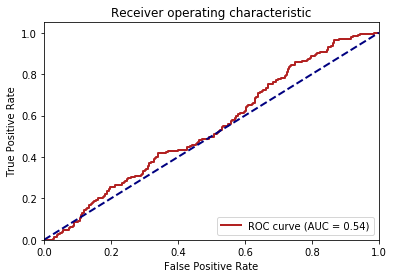

Average precision-recall score: 0.09


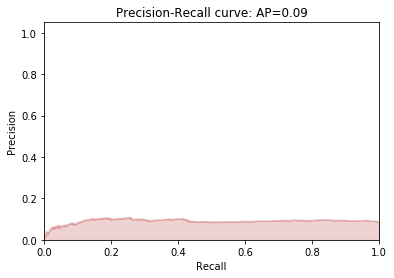

In [323]:
roc_auc, average_precision = calc_metrics(y_gt, y_score, display_graphs=True)

In [324]:
print (mean_grid.shape)
mean_grid = np.multiply(mean_grid,255)
cv2.imwrite("mean_grid.jpg", mean_grid.reshape((mean_grid[0],34,60)))




(2, 34, 60)


TypeError: only integer scalar arrays can be converted to a scalar index

In [325]:
maxi = np.amax(mean_grid)
print (maxi)

174.103716113311


## Autoencoder

### 1D Autoencoder

In [326]:


X_train_flat, X_test_flat = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))), X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


In [327]:
input_dim = np.prod(grids.shape[1:])
encoding_dim = 14

print(input_dim)

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

4080


In [328]:
nb_epoch = 50
batch_size = 32

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="models/model.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train_flat, X_train_flat,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test_flat, X_test_flat),
                    verbose=1,
                    callbacks=[checkpointer]).history

Train on 6566 samples, validate on 9848 samples
Epoch 1/50
6566/6566 [==============================] - 5s 720us/step - loss: 0.0724 - acc: 0.0000e+00 - val_loss: 0.0713 - val_acc: 0.0000e+00
Epoch 2/50
6566/6566 [==============================] - 3s 412us/step - loss: 0.0649 - acc: 0.0000e+00 - val_loss: 0.0678 - val_acc: 0.0000e+00
Epoch 3/50
6566/6566 [==============================] - 3s 433us/step - loss: 0.0628 - acc: 0.0000e+00 - val_loss: 0.0670 - val_acc: 1.0154e-04
Epoch 4/50
6566/6566 [==============================] - 3s 442us/step - loss: 0.0612 - acc: 0.0000e+00 - val_loss: 0.0648 - val_acc: 5.0772e-04
Epoch 5/50
6566/6566 [==============================] - 3s 417us/step - loss: 0.0597 - acc: 0.0011 - val_loss: 0.0643 - val_acc: 1.0154e-04
Epoch 6/50
6566/6566 [==============================] - 3s 418us/step - loss: 0.0582 - acc: 0.0011 - val_loss: 0.0629 - val_acc: 2.0309e-04
Epoch 7/50
6566/6566 [==============================] - 3s 433us/step - loss: 0.0573 - acc: 3.04

In [329]:
autoencoder = load_model('models/model.h5')

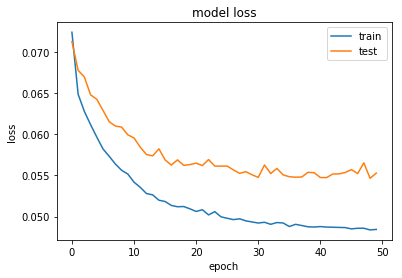

In [330]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [331]:
predictions = autoencoder.predict(X_test_flat)

In [332]:
mse = np.mean(np.power(X_test_flat - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'frameId': Id_test,
                        'second_count': sec_count_test})


In [333]:
threshold = 0.08
interval = 2  # in seconds

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


Anomaly detected at :  28  mins  18  seconds
Anomaly detected at :  28  mins  23  seconds
Anomaly detected at :  28  mins  59  seconds
Anomaly detected at :  29  mins  5  seconds
Anomaly detected at :  29  mins  16  seconds
Anomaly detected at :  29  mins  50  seconds
Anomaly detected at :  30  mins  0  seconds
Anomaly detected at :  30  mins  5  seconds
Anomaly detected at :  30  mins  12  seconds
Anomaly detected at :  30  mins  51  seconds
Anomaly detected at :  31  mins  4  seconds
Anomaly detected at :  31  mins  10  seconds
Anomaly detected at :  31  mins  53  seconds
Anomaly detected at :  32  mins  2  seconds
Anomaly detected at :  32  mins  8  seconds
Anomaly detected at :  32  mins  37  seconds
Anomaly detected at :  32  mins  59  seconds
Anomaly detected at :  33  mins  35  seconds
Anomaly detected at :  33  mins  43  seconds
Anomaly detected at :  35  mins  30  seconds
Anomaly detected at :  36  mins  10  seconds
Anomaly detected at :  37  mins  8  seconds
Anomaly detected 

In [334]:


y_score_test = np.zeros((y_gt_test.shape[0]), dtype = np.float64)

for i in range(y_score_test.shape[0]):
    y_score_test[i] = max(error_df.reconstruction_error.values[clip_size*i:clip_size*(i+1)])
    

ROC_AUC: 0.48


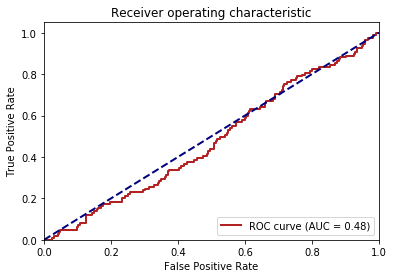

Average precision-recall score: 0.08


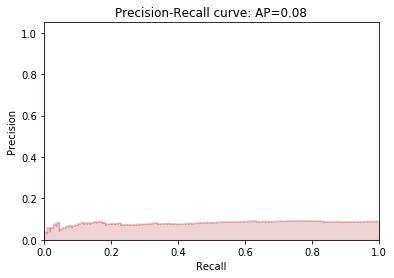

In [335]:
roc_auc, average_precision = calc_metrics(y_gt_test, y_score_test, display_graphs=True)

### 2D Convolutional Autoencoder

In [336]:
input_dim = (grids.shape[1], grids.shape[2], grids.shape[3])

print(input_dim)


input_img = Input(shape=input_dim)  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same', data_format="channels_first")(input_img)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
encoded = MaxPooling2D((2, 2), padding='same', data_format="channels_first")(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(encoded)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
x = Conv2D(16, (4, 3), activation='relu', data_format="channels_first")(x)
x = UpSampling2D((2, 2), data_format="channels_first")(x)
decoded = Conv2D(grids.shape[1], (3, 3), activation='sigmoid', padding='same', data_format="channels_first")(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

(2, 34, 60)


In [ ]:
checkpointer = ModelCheckpoint(filepath="models/model_2D_conv.h5",
                               verbose=0,
                               save_best_only=True)


history = autoencoder.fit(X_train, X_train,
                epochs=4,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_test, X_test),
                callbacks=[checkpointer]).history

Train on 6566 samples, validate on 9848 samples
Epoch 1/4
6566/6566 [==============================] - 173s 26ms/step - loss: 0.2577 - val_loss: 0.1384
Epoch 2/4
6566/6566 [==============================] - 175s 27ms/step - loss: 0.1114 - val_loss: 0.1017
Epoch 3/4
6560/6566 [============================>.] - ETA: 0s - loss: 0.0935

In [133]:
autoencoder = load_model('models/model_2D_conv.h5')

In [134]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2, 34, 60)         0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 34, 60)        304       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 17, 30)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 8, 17, 30)         1160      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 8, 9, 15)          0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 8, 9, 15)          584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 5, 8)           0         
__________

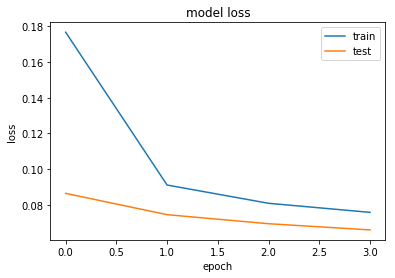

In [135]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [136]:
predictions = autoencoder.predict(X_test)

In [137]:
mse = np.mean(np.power(X_test - predictions, 2), axis=(1,2,3))
print(mse.shape)
error_df = pd.DataFrame({'reconstruction_error': mse.reshape((len(mse),)),
                        'frameId': Id_test,
                        'second_count': sec_count_test})




(3283,)


In [144]:
threshold = 0.015
interval = 1

y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
pred_frameIds = []
pred_second_counts = []
for y,frameId,sec_count in zip(y_pred, Id_test, sec_count_test):
    if y==1:
        pred_frameIds.append(frameId)
        pred_second_counts.append(sec_count)
pred_frameIds.sort()
pred_second_counts.sort()


for i, second_count in enumerate(pred_second_counts):
    if second_count-pred_second_counts[max(i-1,0)] > interval:
        print ('Anomaly detected at : ', int(second_count/60), ' mins ', second_count%60, ' seconds')
    


    



Anomaly detected at :  55  mins  52  seconds
Anomaly detected at :  56  mins  37  seconds
Anomaly detected at :  57  mins  0  seconds
Anomaly detected at :  57  mins  5  seconds
Anomaly detected at :  57  mins  9  seconds
Anomaly detected at :  57  mins  11  seconds
Anomaly detected at :  57  mins  20  seconds
Anomaly detected at :  57  mins  47  seconds
Anomaly detected at :  57  mins  53  seconds
Anomaly detected at :  58  mins  4  seconds
Anomaly detected at :  58  mins  11  seconds
Anomaly detected at :  58  mins  17  seconds
Anomaly detected at :  58  mins  19  seconds
Anomaly detected at :  61  mins  43  seconds
Anomaly detected at :  61  mins  46  seconds
Anomaly detected at :  62  mins  6  seconds
Anomaly detected at :  62  mins  32  seconds
Anomaly detected at :  62  mins  46  seconds
Anomaly detected at :  62  mins  50  seconds
Anomaly detected at :  63  mins  34  seconds
Anomaly detected at :  63  mins  54  seconds
Anomaly detected at :  63  mins  59  seconds
Anomaly detecte